# Probabilistic Programming

### Preliminaries

- Goal 
  - Learn to write basic probabilistic programs
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - Intro to programming in Julia (https://youtu.be/8h8rQyEpiZA?t=233).
    - Getting started with ForneyLab (https://biaslab.github.io/forneylab/docs/getting-started/).
    - Tutorials using Turing.jl (https://turing.ml/dev/tutorials/0-introduction/)

You've been deriving results by hand, but now we are to going to automate some of the labour. In this module, we will introduce you to writing probabilistic programs. We will show how to specify models and inference procedures using probabilistic programming toolboxes. Firstly, we will go throught the problem set you've seen in a previous lecture; clustering with Gaussian mixture models. Secondly, we will give you two problem sets to complete in class where you will see the strengths and weaknesses of the two major approaches to probabilistic programming. Thirdly, we will give you a series of problem sets to complete in your own time which we will discuss with you in class. 

### Mixture modeling - Synthetic data

We will first generate a synthetic data set to play around. This will let us focus on the data-generating process and on the point that a good model should follow the data-generating process.

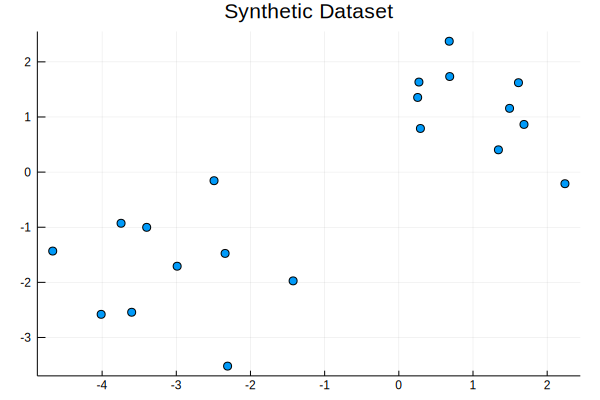

In [1]:
using Distributions
using StatsPlots
using Random

# Set a random seed.
Random.seed!(3)

# Construct 30 data points for each cluster.
N = 10

# Means for each cluster, assuming each cluster is Gaussian distributed
μ1 = [-3.5, -1]
μ2 = [1.0, 1.0]

# Concatenate means
μs = [μ1 μ2]

# Construct the data points.
X = mapreduce(c -> rand(MvNormal(μs[:, c], 1.), N), hcat, 1:2)

# Visualization.
scatter(X[1,:], X[2,:], legend = false, title = "Synthetic Dataset")

In [2]:
using Turing
using MCMCChains
Turing.setadbackend(:forward_diff);

In [3]:
@model GaussianMixtureModel(x, m1, m2) = begin
    
    D, N = size(x)

    # Draw the mean for cluster 1 [2x1 vector]
    μ1 ~ MvNormal(m1, 1.)
    
    # Draw the mean for cluster 2 [2x1 vector]
    μ2 ~ MvNormal(m2, 1.)
    
    # Concatenate means [2x2 matrix]
    μ = [μ1 μ2]
    
    # Probability of belonging to each cluster [2x1 vector]
    w = [0.5, 0.5]
    
    # Preallocate assignment vector [Nx1 vector]
    k = Vector{Int}(undef, N)
    
    # Loop over observations
    for i in 1:N
        
        # Draw assignment for i-th sample from a Categorical distribution parameterized by w
        k[i] ~ Categorical(w)
        
        # Data point x[i] follows a normal distribution, with mean indexed by the assignment variable k[i]
        x[:,i] ~ MvNormal(μ[:, k[i]], 1.)
    end
    
    # Return the assignments
    return k
end

GaussianMixtureModel (generic function with 4 methods)

In [4]:
# Set priors
m1 = [-2, -2]
m2 = [0, 0]

# Create an instance of a model, using the synthetic data set X
gmm_model = GaussianMixtureModel(X, m1, m2);

We now have a data set and a model. To arrive at class assignments for each data point, we need to perform inference. As stated before, there are two main schools of thought in Bayesian inference: Monte Carlo sampling and variational approximations. Below, we will use a particular form of Monte Carlo sampling, called Gibbs sampling.

In [5]:
# Construct Gibbs sampler
gmm_sampler = Gibbs(100, PG(100, 1, :k), HMC(1, 0.05, 10, :μ1, :μ2))

# Start sampling
tchain = mapreduce(c -> sample(gmm_model, gmm_sampler), chainscat, 1);

[Gibbs] Sampling...100% Time: 0:00:36
┌ Info: [Gibbs] Finished with
└ @ Turing.Inference /home/wmkouw/.julia/packages/Turing/RZOZ8/src/inference/gibbs.jl:185
┌ Info:   Running time    = 35.779411899999985;
└ @ Turing.Inference /home/wmkouw/.julia/packages/Turing/RZOZ8/src/inference/gibbs.jl:186


In [6]:
# Extract the means over the MCMC chains for the posterior means
μ1_estimated = vec(convert(Array{Float64,2}, mean(tchain[:μ1].value.data[:,:,1]; dims=1)));
μ2_estimated = vec(convert(Array{Float64,2}, mean(tchain[:μ2].value.data[:,:,1]; dims=1)));

# Report difference between estimated mean and true mean for cluster 1
println("Difference between μ1 and μ1_estimated = "*string(abs.(μ1 - μ1_estimated)))

# Report difference between estimated mean and true mean for cluster 2
println("Difference between μ2 and μ2_estimated = "*string(abs.(μ2 - μ2_estimated)))

Difference between μ1 and μ1_estimated = [0.503557, 0.72829]
Difference between μ2 and μ2_estimated = [0.0690386, 0.0376548]


In [7]:
function predict(x, y, w, μ1, μ2)
    "Compute posterior probabilities of samples under model"
    
    # Probability under cluster 1
    p1 = log(w[1]) + logpdf(MvNormal(μ1, 1.), [x, y])
    
    # Probability under cluster 2
    p2 = log(w[2]) + logpdf(MvNormal(μ2, 1.), [x, y])
    
    # Add probabilities using log-sum-exp trick for numeric stability.
    return Turing.logaddexp(p1, p2)
end

predict (generic function with 1 method)

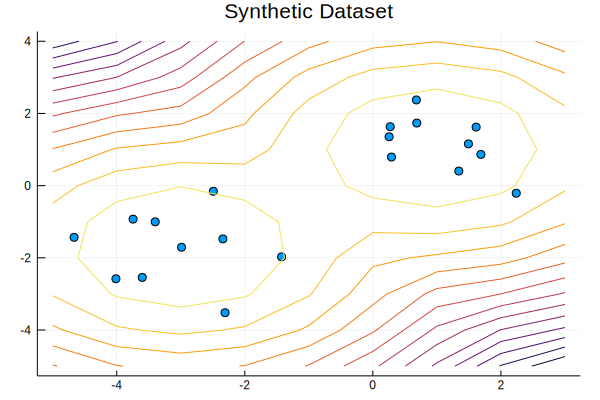

In [8]:
# Show the data
scatter(X[1,:], X[2,:], legend = false, title = "Synthetic Dataset")

# Overlay the posterior probability
x1 = range(-5, stop=3)
x2 = range(-5, stop=4)
contour!(x1, x2, (x, y) -> predict(x, y, [0.5, 0.5], μ1_estimated, μ2_estimated))

Let's take a closer look at the chain. 

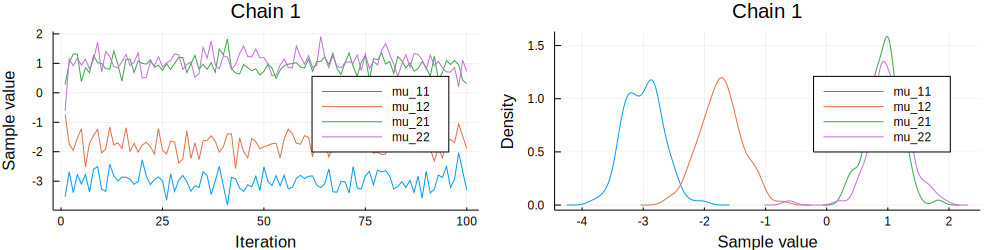

In [9]:
# Find the means within the chain
ids = findall(map(name -> occursin("μ", name), names(tchain)));

# Plot the course of the chains
p=plot(tchain[:, ids, :], legend=true, labels = ["mu_11" "mu_12" "mu_21" "mu_22"], colordim=:parameter)

### Mixture modeling - natural data

Let's have another look at the Old Faithful data set. 

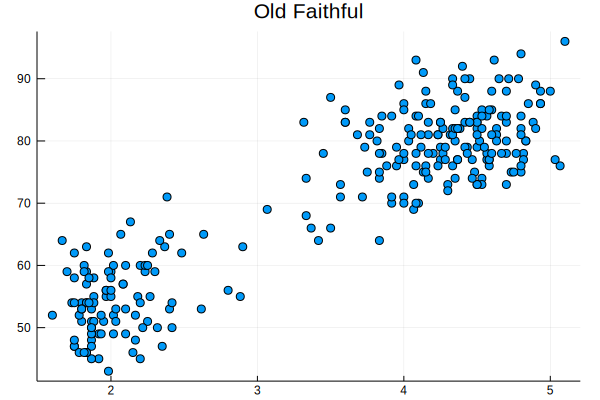

In [10]:
using DataFrames
using CSV
using LinearAlgebra

# Read file
old_faithful = CSV.read("datasets/old_faithful.csv")

# Convert file to matrix
X = convert(Matrix{Float64}, [old_faithful[1] old_faithful[2]])

# Scatter data points
scatter(X[:,1], X[:,2], legend=false, title="Old Faithful")

First of all, we should specify the model that we believe generated the data. 

In [11]:
# Set priors
m1 = [2, 50]
m2 = [4, 80]

# Call another instance of the model for this data set
gmm_model = GaussianMixtureModel(X', m1, m2);

In [12]:
# Construct a Gibbs sampler
gmm_sampler = Gibbs(50, PG(100, 1, :k), HMC(1, 0.05, 10, :μ1, :μ2))

# Start sampling
tchain = mapreduce(c -> sample(gmm_model, gmm_sampler), chainscat, 1);

[Gibbs] Sampling...100% Time: 0:25:13
┌ Info: [Gibbs] Finished with
└ @ Turing.Inference /home/wmkouw/.julia/packages/Turing/RZOZ8/src/inference/gibbs.jl:185
┌ Info:   Running time    = 1512.9509058859996;
└ @ Turing.Inference /home/wmkouw/.julia/packages/Turing/RZOZ8/src/inference/gibbs.jl:186


As you may start to realize, sampling is slow.

In [13]:
# Means of distributions
μ1_estimated = vec(convert(Array{Float64,2}, mean(tchain[:μ1].value.data[:,:,1]; dims=1)));
μ2_estimated = vec(convert(Array{Float64,2}, mean(tchain[:μ2].value.data[:,:,1]; dims=1)));

# Report estimated mean for each cluster
println("μ1_estimated = "*string(μ1_estimated))
println("μ2_estimated = "*string(μ2_estimated))

μ1_estimated = [2.09885, 54.2743]
μ2_estimated = [4.23513, 79.9564]


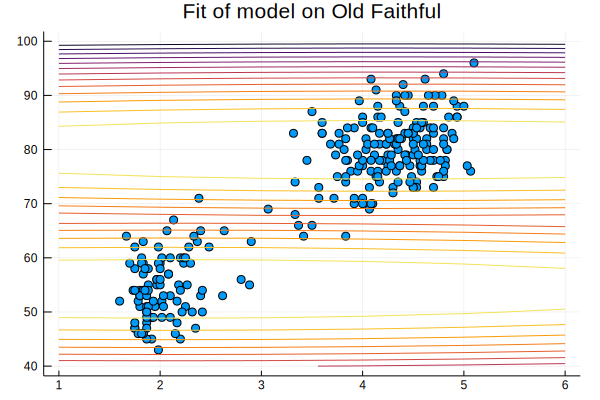

In [14]:
# Plot iso-probability lines
x1 = range(1, stop = 6)
x2 = range(40, stop = 100)

# Scatter points
scatter(X[:, 1], X[:,2], legend=false, title="Fit of model on Old Faithful")
contour!(x1, x2, (x, y) -> predict(x, y, [0.5, 0.5], μ1_estimated, μ2_estimated))

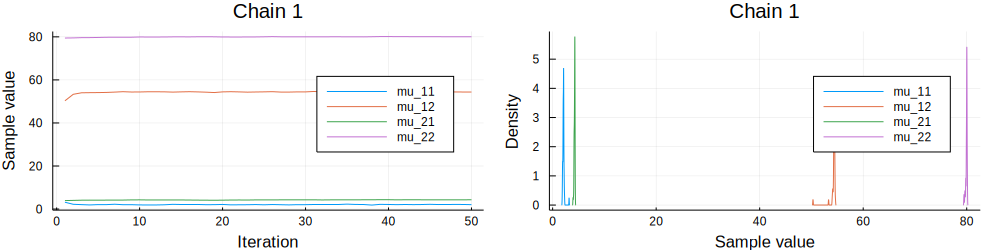

In [15]:
# Find the means within the chain
ids = findall(map(name -> occursin("μ", name), names(tchain)));

# Plot the course of the chains
p=plot(tchain[:, ids, :], legend=true, labels = ["mu_11" "mu_12" "mu_21" "mu_22"], colordim=:parameter)

### Inference through variational approximation